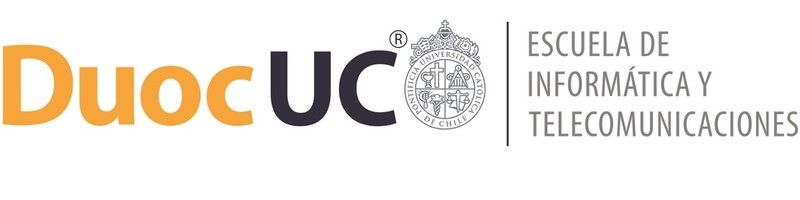

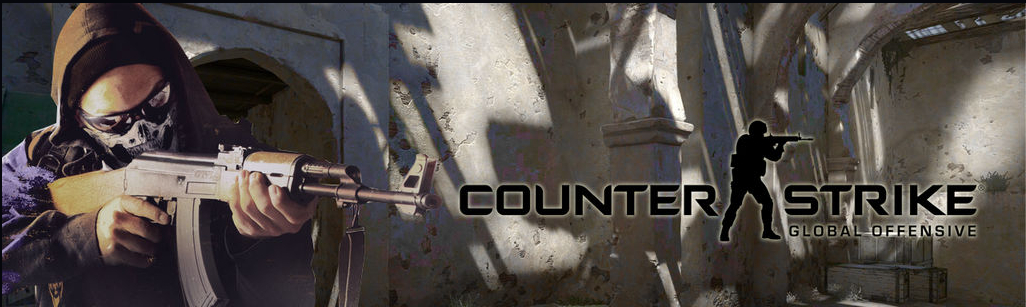

# Informe Técnico - Examen Transversal: Caso Counter Strike


Integrantes:
*
*

Docente:     

Sección: MLY0100 -

# Caso Fundamentos de Machine Learning

CONTEXTO CASO

Valve, los ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.


El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  


Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { Dato } & \text { Descripción } \\
\hline Map & \text {Nombre  del Mapa donde se jugó la partida}  \\
\hline \text{ Team} & \text { Nombre de equipo al que pertenece el jugador} \\
\hline \text{ InternalTeamId} & \text { Identificador del equipo al que pertenece el jugador.} \\
\hline \text{ MatchId} & \text { Identificador de la partida.} \\
\hline \text{ RoundId} & \text { Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas)} \\
\hline \text{ MatchWinner} & \text { Indica si el jugador ganó o no la partida.} \\
\hline \text{ RoundWinner} & \text { Indica si el jugador ganó o no la ronda analizada.} \\
\hline \text{ Survived} & \text { Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar).} \\
\hline \text{ AbnormalMatch} & \text { Indica si la partida del jugador tuvo un error por conexión de red} \\
\hline \text{ TimeAlive} & \text { Indica el tiempo en segundos que el jugador estuvo vivo durante el juego} \\
\hline \text{ TravelledDistance} & \text { Distancia viajada por el jugador durante la partida.} \\
\hline \text{ RLethalGrenadesThrown/RNonLethalGrenadesThrown} & \text { Cantidad de granadas lanzadas, categorizadas en letales y no-letales.} \\
\hline \text{ PrimaryXXXX} & \text { Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol.} \\
\hline \text{ [Match|Round] Assists} & \text { Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] Kills} & \text { Cantidad de kills efectuados por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] FlankKills} & \text { Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda.} \\
\hline \text{ [Match|Round] HeadShots} & \text { Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda.} \\
\hline \text{ RoundStartingEquipmentValue} & \text { Valor del equipamiento llevado por el jugador al inicio de la ronda.} \\
\hline \text{ TeamStartingEquipmentValue} & \text { Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda.} \\
\end{array}
\end{aligned}
$$

## Fase 1: Business Understanding

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Librerias para modelos y métricas de regresión
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import svm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Librerias para modelos y métricas de clasificación

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler


#Librería para puesta en producción
import pickle as pickle
from joblib import dump

# Configuración de advertencias
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=None, engine='python')

# las primeras filas
print(df.head())

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022 (4).csv
   Unnamed: 0         Map       Team  InternalTeamId  MatchId  RoundId  \
0         600  de_inferno  Terrorist               1        4        1   
1         601  de_inferno  Terrorist               1        4        1   
2         602  de_inferno  Terrorist               1        4        1   
3         603  de_inferno  Terrorist               1        4        1   
4         604  de_inferno  Terrorist               1        4        1   

  RoundWinner MatchWinner  Survived  AbnormalMatch  ... RoundKills  \
0       False        True     False          False  ...          0   
1       False        True     False          False  ...          0   
2       False        True     False          False  ...          0   
3       False        True     False          False  ...          0   
4       False        True      True          False  ...          0   

  RoundAssists  RoundHeadshots  RoundFlankKills 

## Fase 1

El objetivo principal es comprender el comportamiento de los jugadores y generar modelos predictivos que permitan identificar patrones.

Preguntas de Regresión
- ¿Los headshots influyen en las cantidad total de kills en la partida?
- ¿Que probabilidad tiene un jugador de ganar la partida si gana la primera ronda?
- ¿Que probabilidad tiene un jugador de sobrevivir la ronda?

Preguntas de Clasificación
- ¿Hubo jugadores que no jugaron?
- Según el rendimiento del jugador ¿se puede clasificar si ganara o perdera la partida?

## Fase 2: Data Understanding

In [ ]:
df.shape
# 79,157 datos y 30 columnas.

(79157, 30)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId',
       'RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive',
       'TravelledDistance', 'RLethalGrenadesThrown',
       'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle',
       'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
       'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
       'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue',
       'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'],
      dtype='object')

In [ ]:
df.head()

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,0,0,0,0,1000,4400,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
Map,0
Team,2
InternalTeamId,0
MatchId,0
RoundId,0
RoundWinner,0
MatchWinner,1
Survived,0
AbnormalMatch,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,79157.0,60570.193640,36436.598386,600.0,30830.0,56720.0,90639.0,123779.0
InternalTeamId,79157.0,1.500006,0.500003,1.0,1.0,2.0,2.0,2.0
MatchId,79157.0,250.525033,149.557804,4.0,128.0,236.0,373.0,511.0
RoundId,79157.0,12.765517,7.432837,1.0,6.0,12.0,19.0,36.0
RLethalGrenadesThrown,79157.0,0.498667,0.597985,0.0,0.0,0.0,1.0,4.0
RNonLethalGrenadesThrown,79157.0,1.258057,1.184909,0.0,0.0,1.0,2.0,6.0
PrimaryAssaultRifle,79157.0,0.675363,0.464125,0.0,0.0,1.0,1.0,1.0
PrimarySniperRifle,79157.0,0.089840,0.279797,0.0,0.0,0.0,0.0,1.0
PrimaryHeavy,79157.0,0.005964,0.075497,0.0,0.0,0.0,0.0,1.0
PrimarySMG,79157.0,0.007046,0.082453,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.columns

df2=df.drop(['Unnamed: 0'],axis=1)

In [ ]:
df2.columns

Index(['Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner',
       'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive',
       'TravelledDistance', 'RLethalGrenadesThrown',
       'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle',
       'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
       'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
       'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue',
       'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots'],
      dtype='object')

In [ ]:
import pandas as pd

# Convertir columnas a numericas
for col in ['TimeAlive', 'TravelledDistance', 'FirstKillTime']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convertir MatchWinner a numero
df['MatchWinner'] = df['MatchWinner'].map({True: 1, False: 0})

# Codificar las columnas categóricas
df_encoded = pd.get_dummies(df, columns=['Map', 'RoundWinner'], prefix=['Map', 'RoundWinner'])

# Seleccionar columnas numéricas
df_encoded_numeric = df_encoded.select_dtypes(include=['number'])

# Verificar que 'MatchWinner'
if 'MatchWinner' in df_encoded_numeric.columns:
    corr_matrix = df_encoded_numeric.corr()

# Ordenar por correlación con MatchWinner
    corr_with_match_winner = corr_matrix['MatchWinner'].sort_values(ascending=False)
    print(corr_with_match_winner)
else:
    print("La columna 'MatchWinner' sigue sin ser numérica o tiene problemas.")

MatchWinner                    1.000000
PrimaryPistol                  0.138741
PrimaryHeavy                   0.011190
Unnamed: 0                    -0.013365
MatchId                       -0.013441
RoundId                       -0.019090
TimeAlive                     -0.020782
PrimarySMG                    -0.029460
PrimarySniperRifle            -0.029837
RoundFlankKills               -0.045298
RoundAssists                  -0.060199
RoundHeadshots                -0.067328
InternalTeamId                -0.079463
RNonLethalGrenadesThrown      -0.087328
TravelledDistance             -0.097202
PrimaryAssaultRifle           -0.102791
RoundKills                    -0.107758
MatchFlankKills               -0.111153
FirstKillTime                 -0.115000
MatchHeadshots                -0.149796
RLethalGrenadesThrown         -0.152961
MatchAssists                  -0.161667
RoundStartingEquipmentValue   -0.175745
MatchKills                    -0.186304
TeamStartingEquipmentValue    -0.190419


In [ ]:
# filas donde no hubo kills, assists o headshots
df.query('MatchKills == 0 or MatchAssists == 0 or MatchHeadshots == 0')


,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,de_inferno,Terrorist,1,4,1,False,1.0,True,False,...,0,0,0,0,1000,4400,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79147,123770,de_mirage,Terrorist,1,511,5,True,1.0,False,False,...,2,0,1,0,4200,14700,5,1,0,2
79148,123771,de_mirage,Terrorist,1,511,5,True,1.0,False,False,...,0,0,0,0,2300,14700,0,0,1,0
79150,123773,de_mirage,Terrorist,1,511,5,True,1.0,False,False,...,0,0,0,0,2750,14700,0,0,0,0
79151,123774,de_mirage,Terrorist,1,511,5,True,1.0,False,False,...,1,0,0,0,2550,14700,2,0,0,1


In [ ]:
# Mostrar cuántas filas cumplen la condición
df.query('MatchKills == 0 and MatchAssists == 0 and MatchHeadshots == 0').shape[0]


3433

[Text(0, 0, 'de_inferno'),
 Text(1, 0, 'de_nuke'),
 Text(2, 0, 'de_mirage'),
 Text(3, 0, 'de_dust2')]

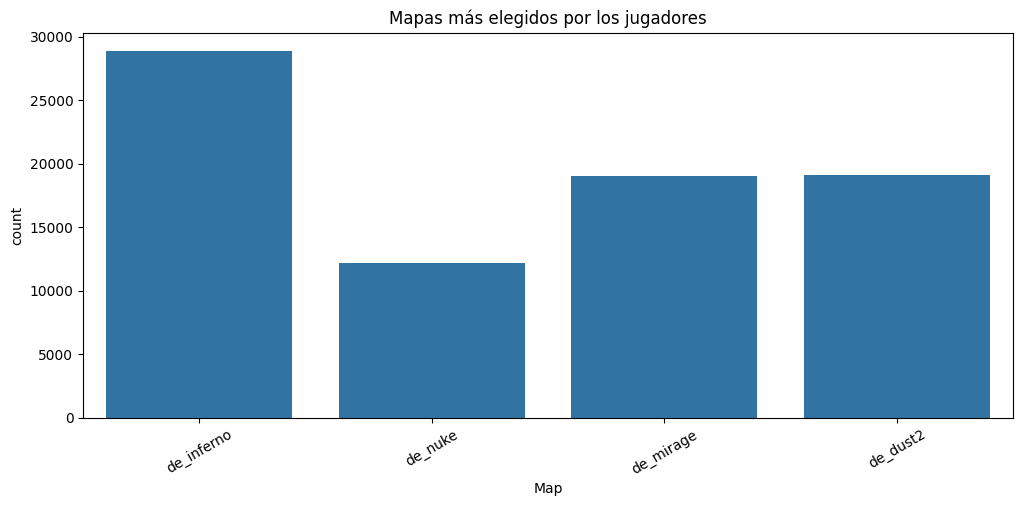

In [ ]:
# Gráfico de barras de los mapas
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5)) #Generar grilla para graficos
fig.subplots_adjust(hspace=0.5)

sns.countplot(x=df.Map, data=df, ax=ax)
ax.set_title("Mapas más elegidos por los jugadores")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

Interpretacion: El mapa de_inferno es el mapa más elegido por los jugadores siendo seleccionados casi 30k y el mapa de_nuke es el mapa menos elegido por los jugadores menos de 15k jugadores

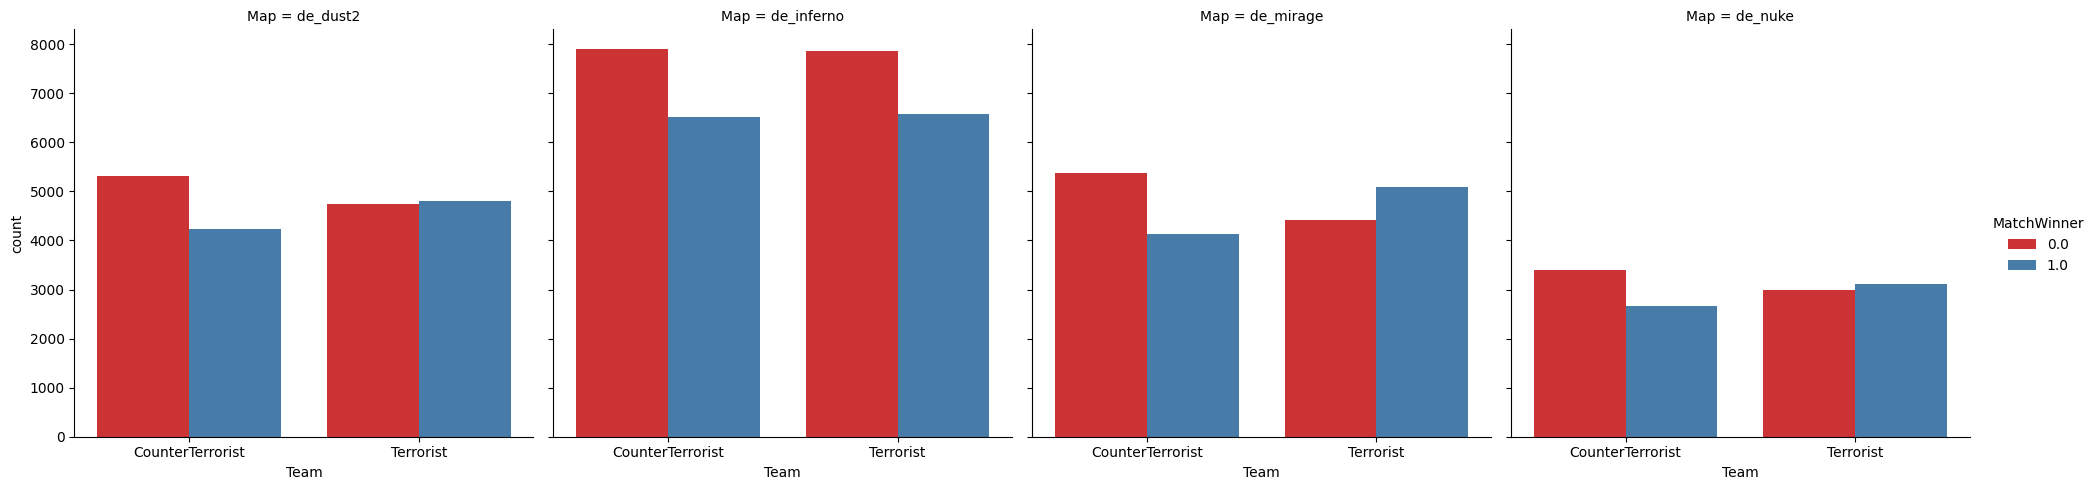

In [ ]:
import seaborn as sns

# Con esto cuento las victorias y derrotas de los equipos
grouped_df = df.groupby(['Team', 'Map', 'MatchWinner']).size().reset_index(name='count')

# Creo un gráfico de barras agrupado por equipo y mapa
sns.catplot(x='Team', y='count', hue='MatchWinner', col='Map', data=grouped_df, kind='bar', palette='Set1')

Interpretacion: Este grafico muestra la cantidad de victorias y derrotas de los jugadores en los distintos mapas donde se demuestra que el mapa mas jugado es de_inferno, Donde esto demuestra que mientras mas se juega un mapa hay mas derrotas ya que es el mapa donde mas se especializan.

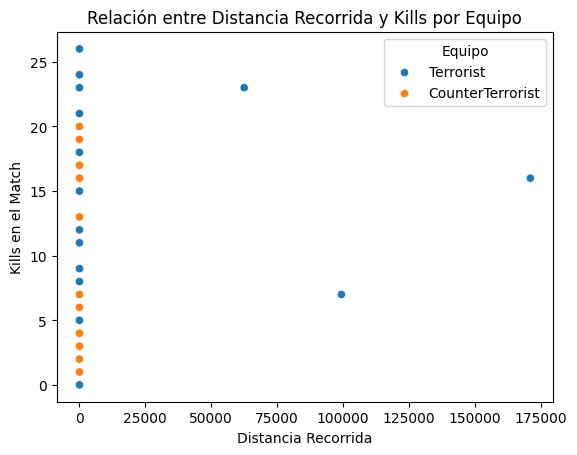

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Asegurar que TravelledDistance sea numérico
df2['TravelledDistance'] = pd.to_numeric(df2['TravelledDistance'], errors='coerce')

# Graficamos: kills vs distancia recorrida, con colores por equipo
sb.scatterplot(x=df2['TravelledDistance'], y=df2['MatchKills'], hue=df2['Team'])
plt.xlabel('Distancia Recorrida')
plt.ylabel('Kills en el Match')
plt.title('Relación entre Distancia Recorrida y Kills por Equipo')
plt.legend(title='Equipo', loc='upper right')
plt.show()



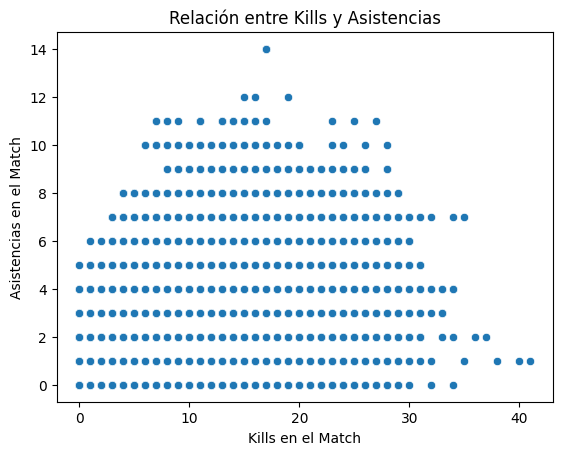

Correlación entre Asistencias y Kills: -0.021481967672222574


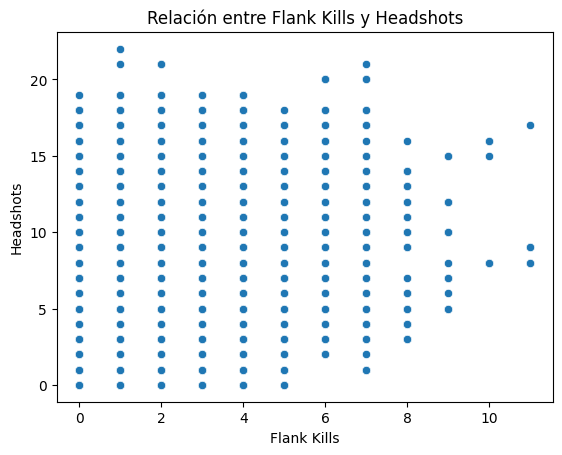

In [ ]:
# kills vs asistencias
sb.scatterplot(x=df2['MatchKills'], y=df2['MatchAssists'])
plt.xlabel('Kills en el Match')
plt.ylabel('Asistencias en el Match')
plt.title('Relación entre Kills y Asistencias')
plt.show()
# Calcular la correlación entre Asistencias y Kills
correlacion = df[['RoundAssists', 'RoundKills']].corr().iloc[0, 1]
print(f"Correlación entre Asistencias y Kills: {correlacion}")

# flank kills vs headshots
sb.scatterplot(x=df2['MatchFlankKills'], y=df2['MatchHeadshots'])
plt.xlabel('Flank Kills')
plt.ylabel('Headshots')
plt.title('Relación entre Flank Kills y Headshots')
plt.show()

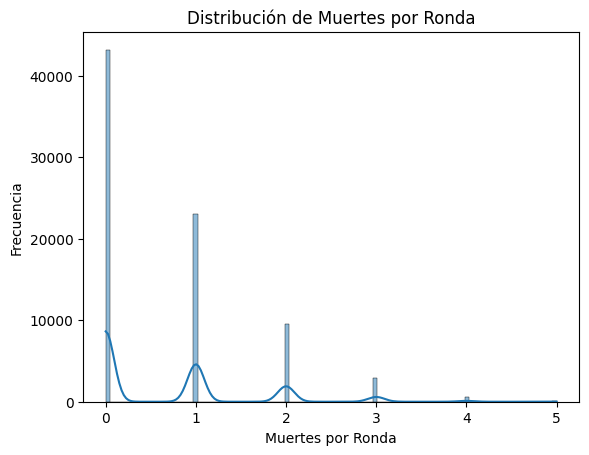

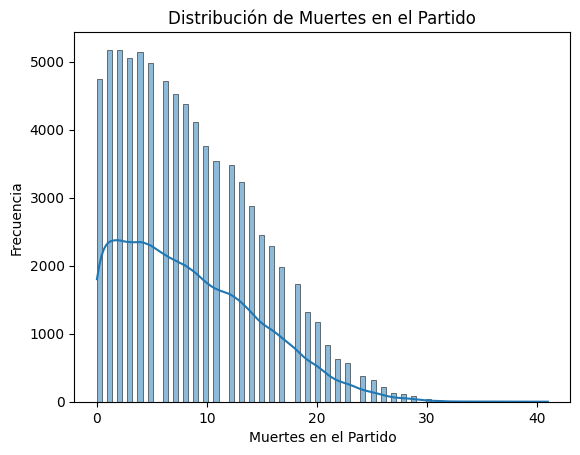

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

# Gráfico de distribución '
sb.histplot(df2['RoundKills'], kde=True)
plt.title('Distribución de Muertes por Ronda')
plt.xlabel('Muertes por Ronda')
plt.ylabel('Frecuencia')
plt.show()

sb.histplot(df2['MatchKills'], kde=True)
plt.title('Distribución de Muertes en el Partido')
plt.xlabel('Muertes en el Partido')
plt.ylabel('Frecuencia')
plt.show()



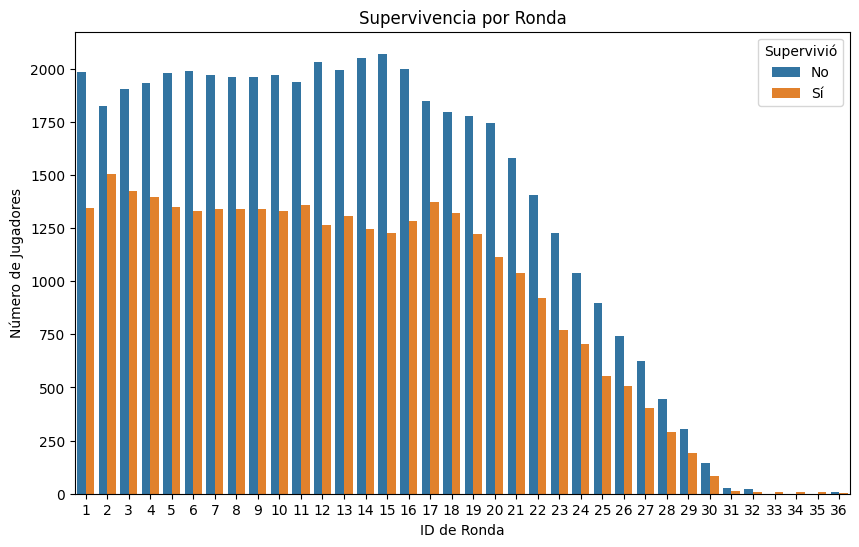

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df2, x='RoundId', hue='Survived')
plt.title('Supervivencia por Ronda')
plt.xlabel('ID de Ronda')
plt.ylabel('Número de Jugadores')
plt.legend(title='Supervivió', loc='upper right', labels=['No', 'Sí'])
plt.show()


Interpretacion: en la mayoria de las rondas los jugarores sobrevivieron

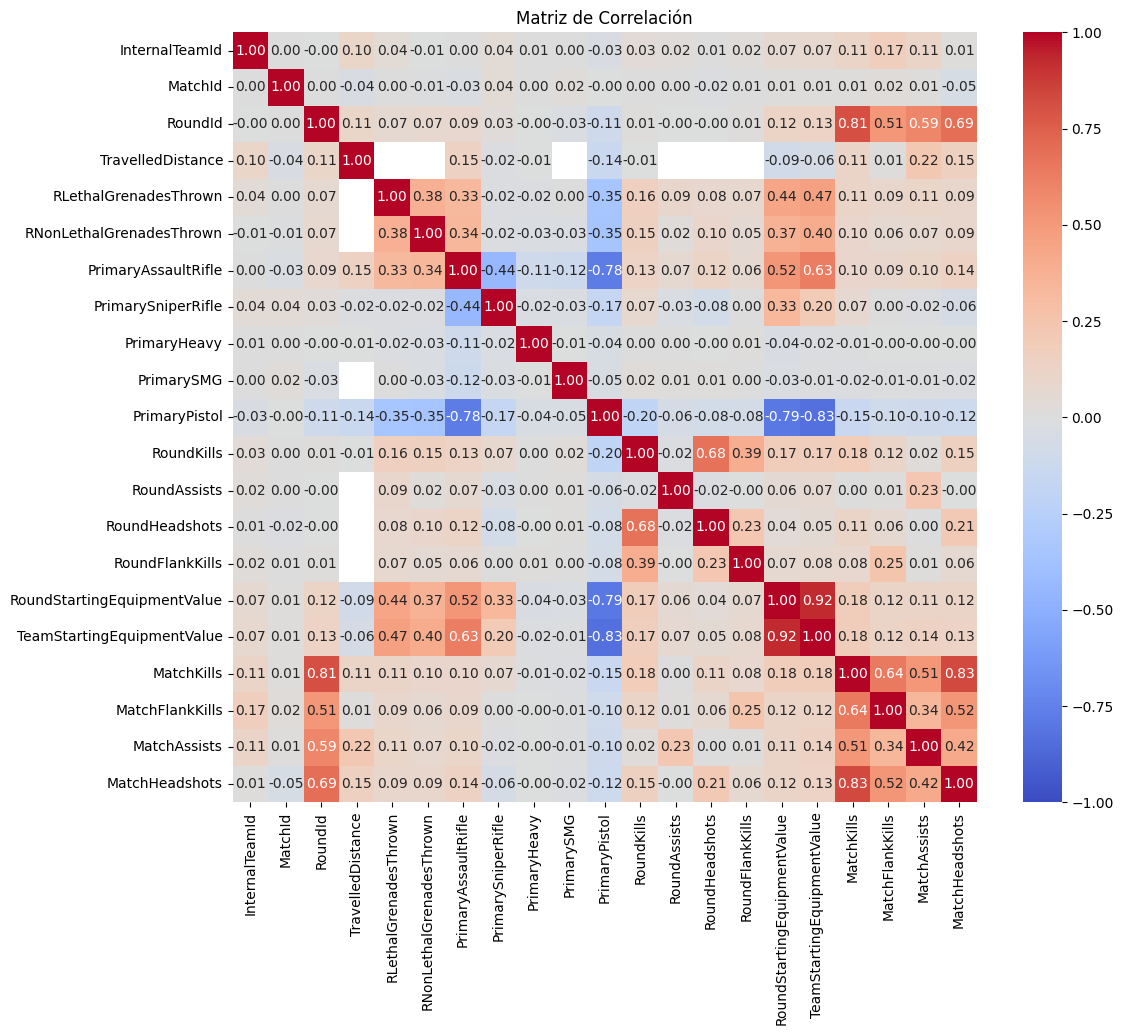

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que df2 es el nombre de tu DataFrame
# Filtramos las columnas numéricas
numeric_data = df2.select_dtypes(include='number')

# Crear la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Título del gráfico
plt.title('Matriz de Correlación')

# Mostrar el gráfico
plt.show()


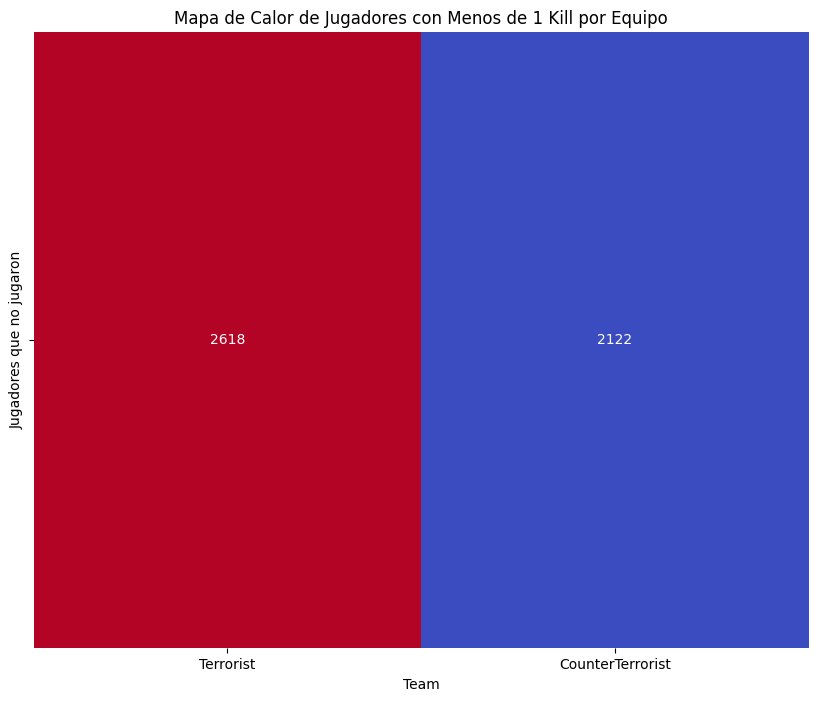

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Jugadores que no hicieron 1 kills
df_filtered = df[df['MatchKills'] < 1]

kill_count = df_filtered['Team'].value_counts()

# Creamos un DataFrame de la cuenta de kills
kill_count_df = pd.DataFrame(kill_count).reset_index()
kill_count_df.columns = ['Team', 'Jugadores que no jugaron']

# Creamos el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(kill_count_df.set_index('Team').T, annot=True, cmap='coolwarm', fmt='g', cbar=False)

# Mostramos el gráfico
plt.title('Mapa de Calor de Jugadores con Menos de 1 Kill por Equipo')
plt.show()


# Calcular la Probabilidad
#¿Que probabilidad tiene un jugador de ganar la partida si gana la primera ronda?

In [ ]:
import pandas as pd

#Normalizar valores
df['RoundWinner'] = df['RoundWinner'].replace({'TRUE': True, 'FALSE': False})
df['GanoPrimeraRonda'] = df['RoundId'] == 1
df_primera_ronda = df[df['GanoPrimeraRonda']]
# Calcular si ganando la primera ronda gana la partida
contingencia_primera = pd.crosstab(df_primera_ronda['RoundWinner'], df_primera_ronda['MatchWinner'])
probabilidad_ganar = contingencia_primera.apply(lambda x: x / x.sum(), axis=1)

print("Probabilidad de ganar la partida si se gana la primera ronda:\n")
print(probabilidad_ganar)


Probabilidad de ganar la partida si se gana la primera ronda:

MatchWinner       0.0       1.0
RoundWinner                    
False        0.289552  0.710448
True         0.764350  0.235650


Interpretacion: La probabilidad de ganar la partida si gana la primera ronda es de 24%, pero la probabilidad de la ganar la partida si pierde la primera ronda es de 71%, lo que indica que la primera partida podria tratarse de una partida de prueba o para analizar el rival

In [ ]:
#respaldo
df_respaldo_reg = df.copy()

## Fase 3: Data Preparation

In [ ]:
# Insertar cuantos bloques de código consideren necesarios

# Se recomienda considerar todas las transformaciones necesarias para obtener la data lo más limpia posible.
# Realizar tratamiento a todos los datos que consideren necesarios.

In [ ]:
# Ver los nombres de las columnas
print(df.columns)


Index(['Unnamed: 0', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId',
       'RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive',
       'TravelledDistance', 'RLethalGrenadesThrown',
       'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle',
       'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime',
       'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
       'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue',
       'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots',
       'GanoPrimeraRonda'],
      dtype='object')


In [ ]:
# Eliminar filas donde la columna 'Team' tiene valores nulos
df_cleaned = df.dropna(subset=['Team'])


In [ ]:
# Eliminar columna
df_cleaned = df.drop(columns=['Unnamed: 0'])


In [ ]:
# Eliminar filas con valores nulos
df_cleaned = df_cleaned.dropna()

# Verificar
print(df_cleaned.isnull().sum())


Map                            0
Team                           0
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    0
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaryPistol                  0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssists                   0
MatchHeadshots                 0
GanoPrimeraRonda               0
dtype: int

In [ ]:
# Verificar
print(df_cleaned.isnull().sum())


Map                            0
Team                           0
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    0
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaryPistol                  0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssists                   0
MatchHeadshots                 0
GanoPrimeraRonda               0
dtype: int

In [ ]:
# 1. Revisamos los primeros datos
df.head()


,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,GanoPrimeraRonda
0,600,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,750,4400,0,0,0,0,True
1,601,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,800,4400,0,0,0,0,True
2,602,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,1000,4400,0,0,0,0,True
3,603,de_inferno,Terrorist,1,4,1,False,1.0,False,False,...,0,0,0,850,4400,0,0,0,0,True
4,604,de_inferno,Terrorist,1,4,1,False,1.0,True,False,...,0,0,0,1000,4400,0,0,0,0,True


In [ ]:
# Buscamos registros anómalos (por ejemplo, más de 10 kills o asistencias en un solo round)
df_cleaned.query('RoundKills > 5 or RoundAssists > 5 or RoundHeadshots > 5')


,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,TimeAlive,...,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,GanoPrimeraRonda


In [ ]:
df_cleaned = df_cleaned[df_cleaned['RoundKills'] <= 5]


In [ ]:
# Jugadores que no sobrevivieron y no hicieron kills
df_cleaned.query('Survived == 0 and RoundKills == 0')
# Eliminarlos
df_cleaned.drop(df_cleaned.query('Survived == 0 and RoundKills == 0').index, inplace=True)
df_cleaned.head()


,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,TimeAlive,...,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,GanoPrimeraRonda
264,de_nuke,Terrorist,1,6,4,False,1.0,True,False,0.0,...,0,0,0,200,5500,0,0,0,0,False
269,de_nuke,CounterTerrorist,2,6,4,True,0.0,True,False,0.0,...,0,0,0,200,6300,0,0,0,0,False
274,de_nuke,Terrorist,1,6,5,False,1.0,True,False,0.0,...,0,0,0,200,5200,0,0,0,0,False
279,de_nuke,CounterTerrorist,2,6,5,True,0.0,True,False,0.0,...,0,0,0,200,1000,0,0,0,0,False
284,de_nuke,Terrorist,1,6,6,True,1.0,True,False,0.0,...,0,0,0,200,9700,0,0,0,0,False


In [ ]:
# Efectividad en la ronda: (kills + assists + headshots)
df_cleaned["RoundEffectiveness"] = df_cleaned.RoundKills + df_cleaned.RoundAssists + df_cleaned.RoundHeadshots
df_cleaned.head()


,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,TimeAlive,...,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,GanoPrimeraRonda,RoundEffectiveness
264,de_nuke,Terrorist,1,6,4,False,1.0,True,False,0.0,...,0,0,200,5500,0,0,0,0,False,0
269,de_nuke,CounterTerrorist,2,6,4,True,0.0,True,False,0.0,...,0,0,200,6300,0,0,0,0,False,0
274,de_nuke,Terrorist,1,6,5,False,1.0,True,False,0.0,...,0,0,200,5200,0,0,0,0,False,0
279,de_nuke,CounterTerrorist,2,6,5,True,0.0,True,False,0.0,...,0,0,200,1000,0,0,0,0,False,0
284,de_nuke,Terrorist,1,6,6,True,1.0,True,False,0.0,...,0,0,200,9700,0,0,0,0,False,0


In [ ]:
df_cleaned.drop(["InternalTeamId", "MatchId", "RoundId"], axis=1, inplace=True)
df_cleaned.head()


,Map,Team,RoundWinner,MatchWinner,Survived,AbnormalMatch,TimeAlive,TravelledDistance,RLethalGrenadesThrown,RNonLethalGrenadesThrown,...,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,GanoPrimeraRonda,RoundEffectiveness
264,de_nuke,Terrorist,False,1.0,True,False,0.0,0.0,0,0,...,0,0,200,5500,0,0,0,0,False,0
269,de_nuke,CounterTerrorist,True,0.0,True,False,0.0,0.0,0,0,...,0,0,200,6300,0,0,0,0,False,0
274,de_nuke,Terrorist,False,1.0,True,False,0.0,0.0,0,0,...,0,0,200,5200,0,0,0,0,False,0
279,de_nuke,CounterTerrorist,True,0.0,True,False,0.0,0.0,0,0,...,0,0,200,1000,0,0,0,0,False,0
284,de_nuke,Terrorist,True,1.0,True,False,0.0,0.0,0,0,...,0,0,200,9700,0,0,0,0,False,0


In [ ]:
# Mapas: les asignamos valores numéricos
df_cleaned.Map.unique()
df_cleaned.Map.replace({
    "Dust2":1, "Mirage":2, "Inferno":3, "Nuke":4, "Overpass":5, "Vertigo":6, "Ancient":7
}, inplace=True)

# Equipos: T (0) y CT (1)
df_cleaned.Team.unique()
df_cleaned.Team.replace({
    "Terrorists":0, "Counter-Terrorists":1
}, inplace=True)

# RoundWinner: mismo proceso
df_cleaned.RoundWinner.unique()
df_cleaned.RoundWinner.replace({
    "Terrorists":0, "Counter-Terrorists":1
}, inplace=True)

# MatchWinner: mismo proceso
df_cleaned.MatchWinner.unique()
df_cleaned.MatchWinner.replace({
    "Terrorists":0, "Counter-Terrorists":1
}, inplace=True)

df_cleaned.head()


,Map,Team,RoundWinner,MatchWinner,Survived,AbnormalMatch,TimeAlive,TravelledDistance,RLethalGrenadesThrown,RNonLethalGrenadesThrown,...,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,GanoPrimeraRonda,RoundEffectiveness
264,de_nuke,Terrorist,False,1.0,True,False,0.0,0.0,0,0,...,0,0,200,5500,0,0,0,0,False,0
269,de_nuke,CounterTerrorist,True,0.0,True,False,0.0,0.0,0,0,...,0,0,200,6300,0,0,0,0,False,0
274,de_nuke,Terrorist,False,1.0,True,False,0.0,0.0,0,0,...,0,0,200,5200,0,0,0,0,False,0
279,de_nuke,CounterTerrorist,True,0.0,True,False,0.0,0.0,0,0,...,0,0,200,1000,0,0,0,0,False,0
284,de_nuke,Terrorist,True,1.0,True,False,0.0,0.0,0,0,...,0,0,200,9700,0,0,0,0,False,0


In [ ]:
# Separar variables
X = df_cleaned.drop(["MatchKills"], axis=1)
y = df_cleaned["MatchKills"]

X.head(), y.head()


(         Map              Team RoundWinner  MatchWinner  Survived  \
 264  de_nuke         Terrorist       False          1.0      True   
 269  de_nuke  CounterTerrorist        True          0.0      True   
 274  de_nuke         Terrorist       False          1.0      True   
 279  de_nuke  CounterTerrorist        True          0.0      True   
 284  de_nuke         Terrorist        True          1.0      True   
 
      AbnormalMatch  TimeAlive  TravelledDistance  RLethalGrenadesThrown  \
 264          False        0.0                0.0                      0   
 269          False        0.0                0.0                      0   
 274          False        0.0                0.0                      0   
 279          False        0.0                0.0                      0   
 284          False        0.0                0.0                      0   
 
      RNonLethalGrenadesThrown  ...  RoundAssists  RoundHeadshots  \
 264                         0  ...             0  

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Paso 4


# Paso 4: Modelos de regresion


# Hipotesis: Los headshots influyen en las cantidad total de kills en la partida


In [1]:
df.columns


NameError: name 'df' is not defined

# Decision Tree

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# limpiAR datos
df_clean = df.dropna(subset=['MatchHeadshots', 'MatchKills'])

# def de variables
X = df_clean[['MatchHeadshots']]
Y = df_clean['MatchKills']

# dividimos el dataset
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=42)

# entrenado el modelo
model = DecisionTreeRegressor(random_state=42)
model.fit(Xtrain, Ytrain)
Yhat = model.predict(Xtest)

# metricas para la evaluacion
print("MSE:", round(mean_squared_error(Ytest, Yhat), 2))
print("MAE:", round(mean_absolute_error(Ytest, Yhat), 2))
print("R^2:", round(r2_score(Ytest, Yhat), 2))
# predicion
headshots_input = input("Inserte la cantidad de headshots: ")
try:
    headshots_val = int(headshots_input)
    entrada = [[headshots_val]]
    kills_pred = model.predict(entrada)[0]
    print(f"Con {headshots_val} headshots, se predicen aproximadamente {kills_pred:.2f} kills.")
except ValueError:
    print("Entrada inválida. Por favor, ingrese un número entero.")


MSE: 11.48
MAE: 2.57
R^2: 0.7
Inserte la cantidad de headshots: 21
Con 21 headshots, se predicen aproximadamente 26.25 kills.


In [ ]:
print("Rango de headshots en los datos:")
print("Mínimo:", X['MatchHeadshots'].min())
print("Máximo:", X['MatchHeadshots'].max())


Rango de headshots en los datos:
Mínimo: 0
Máximo: 22


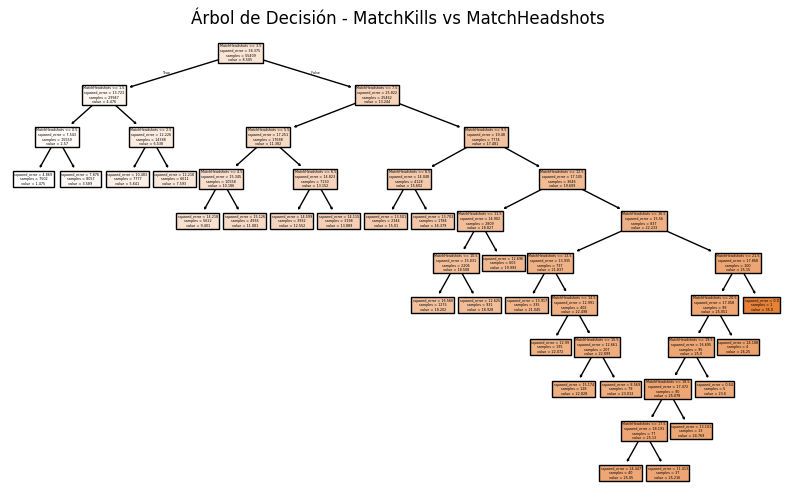

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# árbol de decisión
plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=X.columns, filled=True)
plt.title("Árbol de Decisión - MatchKills vs MatchHeadshots")
plt.show()


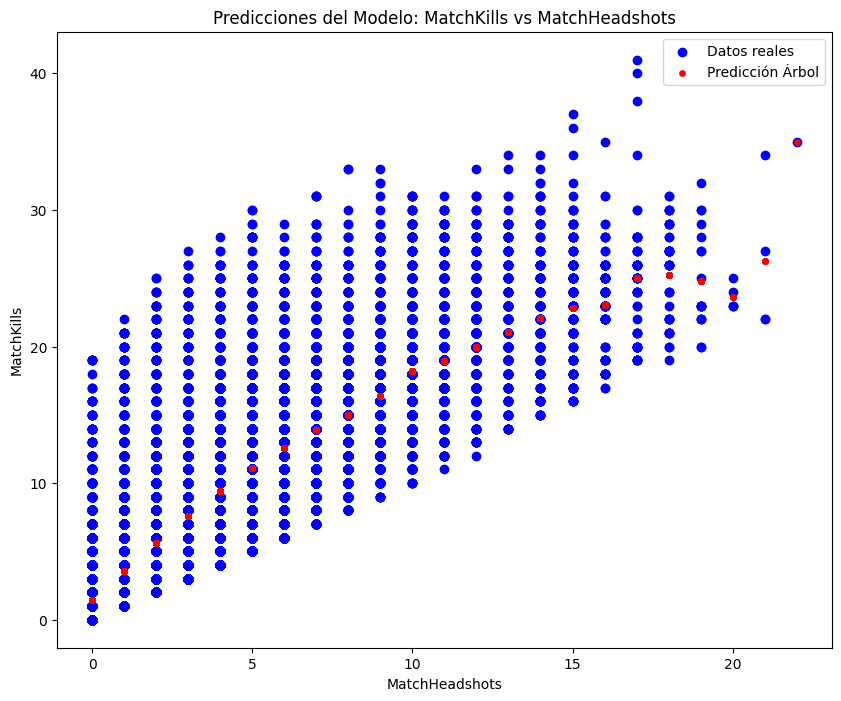

In [ ]:
import matplotlib.pyplot as plt

# Visualización de predicciones del modelo
Y_pred_full = model.predict(X)

plt.figure(figsize=(10, 8))
plt.scatter(X, Y, color='blue', label='Datos reales')
plt.scatter(X, Y_pred_full, color='red', s=15, label='Predicción Árbol')
plt.xlabel('MatchHeadshots')
plt.ylabel('MatchKills')
plt.title('Predicciones del Modelo: MatchKills vs MatchHeadshots')
plt.legend()
plt.show()
